In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision #pacote com funções uteis para imegens
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder #Função útil para lidar com imagens em pastas.
import timm #está aqui para importar arquiteturas que já foram treinadas com imagens para não fazermos do zero
from torch.utils.data import random_split
from torchmetrics.functional import precision, recall

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 1.26.4
Pandas version 2.2.3


In [3]:
# Caminho do dataset
train_path = '/kaggle/input/clouds/clouds/clouds_train'
test_path =  '/kaggle/input/clouds/clouds/clouds_test'

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Carregar e dividir teste
full = ImageFolder(train_path, transform=transform)
train_subset, valid_subset = random_split(full, [int(0.8 * len(full)), len(full) - int(0.8 * len(full))])

# carregar dados teste
test = ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False)
test_loader = DataLoader(test, batch_size=16, shuffle=False)

In [4]:
data_dir = '/kaggle/input/clouds/clouds/clouds_train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'cirriform clouds', 1: 'clear sky', 2: 'cumulonimbus clouds', 3: 'cumulus clouds', 4: 'high cumuliform clouds', 5: 'stratiform clouds', 6: 'stratocumulus clouds'}


In [7]:
class CloudClassifer(nn.Module):
    def __init__(self, num_classes=7):
        super(CloudClassifer, self).__init__()
        # definimos todas as partes do modelo
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # Esta linha aqui está para retirar a última linha do modelo pra que possamos criar uma previsão para o nosso tamanho de classes (abaixo)

        enet_out_size = 1280
        # Fazemos o classificador, ultima camada do modelo
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # conecta as partes acima. É onde realmente ocorre a mudança e vemos a saída dos pesos
        x = self.features(x)
        output = self.classifier(x)
        return output

In [9]:
# Loop de treinamento
num_epochs = 4
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #estamos utilizando o gpu caso tenha

model = CloudClassifer(num_classes=7)
model.to(device) #estamos setando para o modelo rodar no gpu

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Fase treinamento
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/24 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 0.9089002772811849, Validation loss: 1.0465772214688753


Training loop:   0%|          | 0/24 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.6166056581726175, Validation loss: 0.7685114101359719


Training loop:   0%|          | 0/24 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.4576696646166351, Validation loss: 0.519731362869865


Training loop:   0%|          | 0/24 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.4023843397408488, Validation loss: 0.26362028623882094


Training loop:   0%|          | 0/24 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.2671578776553313, Validation loss: 0.6035228861005683


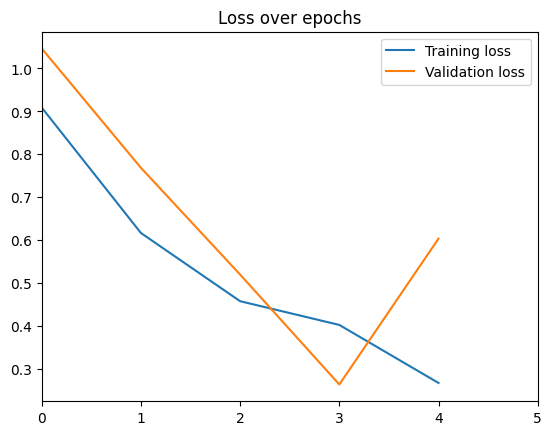

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [15]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatena todas as predições e rótulos
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calcula métricas por classe de forma precisa
precision_per_class = precision(all_preds, all_labels, task="multiclass", num_classes=7, average='none')
recall_per_class = recall(all_preds, all_labels, task="multiclass", num_classes=7, average='none')

# calcula métricas gerais
precision_all = precision(all_preds, all_labels, task="multiclass", num_classes=7, average="macro")
recall_all = recall(all_preds, all_labels, task="multiclass", num_classes=7, average="macro")

print(f"precision: {precision_all}")
print(f"recall: {recall_all}")

# Exibe as métricas
for i, class_name in enumerate(test.classes):
    print(f"{class_name:<25} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f}")

precision: 0.7795991897583008
recall: 0.8236439228057861
cirriform clouds          | Precision: 0.7184 | Recall: 0.9610
clear sky                 | Precision: 0.9545 | Recall: 0.9844
cumulonimbus clouds       | Precision: 0.3333 | Recall: 0.6364
cumulus clouds            | Precision: 0.9870 | Recall: 0.6333
high cumuliform clouds    | Precision: 0.9100 | Recall: 0.8835
stratiform clouds         | Precision: 0.7907 | Recall: 0.8500
stratocumulus clouds      | Precision: 0.7632 | Recall: 0.8169
